# Predicting Newsletter Subscription Using Player Characteristics on a Minecraft Research Server

## Introduction

### Background

The Pacific Laboratory for Artificial Intelligence (PLAI) is a research group in Computer Science at UBC. PLAI operates a Minecraft server called PLAIcraft to study how players behave in a virtual world. As players interact with the environment, their actions and characteristics are recorded. The research group is interested in using this data to target recruitment efforts and ensure the server has adequate resources to handle player demand. A particular focus is predicting which players will subscribe to a game-related newsletter, as subscribers may represent more engaged participants who are valuable for ongoing research.

### Question

**Can player characteristics (including age, total sessions, average session duration, and days active) predict newsletter subscription in the PLAIcraft dataset using a KNN classification model?**

The goal is to build a predictive model that identifies characteristics of players most likely to subscribe, supporting targeted recruitment and communication strategies.

---

## Data Description

This project uses datasets collected automatically from player activity on the PLAIcraft server.


### Players Dataset

- **Number of observations:** *196* players
- **Number of variables:** 7
- **Description:** Contains player characteristics, subscription status, and gameplay hours.

| Variable       | Type      | Meaning                                                                                                                    | # of Missing Observations | Summary Statistics (if applicable)                      |
|----------------|-----------|----------------------------------------------------------------------------------------------------------------------------|--------------------------|----------------------------------------------------------|
| `experience`    | character | The level of experience of the player (Beginner (least experienced), Amateur, Regular, Veteran, Pro (most experienced))    | 0                        | N/A                                                      |
| `subscribe`     | logical   | Whether the player subscribed to the game newsletter (TRUE = subscribed, FALSE = not subscribed)                           | 0                        | N/A                                                      |
| `hashedEmail`   | character | Anonymized unique identifier for each player                                                                               | 0                        | N/A                                                      |
| `played_hours`  | double    | The total number of hours played by the player                                                                             | 0                        | Min = 0, Max = 223.1, Mean = 5.85, SD = 28.36           |
| `name`          | character | The player's name                                                                                                         | 0                        | N/A                                                      |
| `gender`        | character | The player's gender (male, female, non-binary, agender, two-spirited, prefer not to say, other)                           | 0                        | N/A                                                      |
| `age`           | double    | The player's age (years)                                                                                                  | 2                        | Min = 8, Max = 50, Mean = 20.52, Median = 19, Mode = 17, SD = 6.17 |

---

### Sessions Dataset

- **Number of observations:** *1535* sessions 
- **Number of variables:** 5
- **Description:** Contains session level records of player activity.

| Variable               | Type      | Meaning                                                                              | # of Missing Observations | Summary Statistics (if applicable) |
|------------------------|-----------|--------------------------------------------------------------------------------------|--------------------------|-------------------------------------|
| `hashedEmail`           | character | Anonymized unique identifier for each player                                         | 0                        | N/A                                 |
| `start_time`            | string    | Standardized start time of the session (format: day-month-year hour:minute)          | 0                        | N/A                                 |
| `end_time`              | string    | Standardized end time of the session (format: day-month-year hour:minute)            | 0                        | N/A                                 |
| `original_start_time`   | string    | Original start time value recorded by the server                                     | 0                        | N/A                                 |
| `original_end_time`     | string    | Original end time value recorded by the server                                       | 0                        | N/A                                 |

---

### Aggregated Features (Derived from Sessions)

| Variable              | Type    | Meaning                                                    |
|-----------------------|---------|------------------------------------------------------------|
| `total_sessions`       | numeric | Total number of sessions played by the player              |
| `avg_session_duration` | numeric | Average session duration (minutes)                         |
| `days_active`          | numeric | Number of unique days the player was active on PLAIcraft   |

---

### Issues identified

- **Age:** 2 missing values; will require imputation or exclusion.
- **Played hours:** Highly skewed, a small number of players contribute very large amounts of data.
- **Class imbalance:** Fewer subscribers than non-subscribers may affect model accuracy.
- **Categorical variables:** `experience` and `gender` will need encoding for machine learning.
- **Session aggregation:** Summarizing session data at the player level may hide session-level patterns.

---

### Potential unseen issues

- No activity captured outside PLAIcraft.
- Possible inaccuracies in self-reported fields like age or gender.
- Aggregation may miss temporal patterns (e.g., time-of-day effects).

---

### Data collection

- Data was collected automatically by PLAIcraft during normal gameplay.
- No manual data entry, all personal information is anonymized via hashed email.
- No external datasets merged.

---

## Methods & Results

### 1. Loading Data

First, we load the necessary libraries and read the players and sessions datasets from the project’s `data/` folder.

In [557]:
# Load required libraries
library(tidyverse)
library(repr)
library(lubridate)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

In [558]:
# Read player and session data
players_raw <- read_csv("data/players.csv") 
sessions_raw <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



### 2. Cleaning and wrangling the data into a tidy format

The data was cleaned and transformed to prepare it for analysis. We first standardized column names for consistency using `clean_names()`. We converted the `subscribe` variable into a factor to ensure it is treated as a categorical outcome for classification.

For the session data, we converted the `start_time` and `end_time` columns to date-time objects using `dmy_hm()`, and we additionally calculated the duration of each session in minutes.

Next, we summarized the session data for each player to calculate:
- **total_sessions**: the total number of sessions each player completed
- **avg_session_duration**: the mean duration of a player’s sessions (in minutes)
- **days_active**: the number of unique days a player was active on the server

Finally, I merged these session summaries with the player data. For players who had no session data, any missing values (NAs) in the session summaries were replaced with zeros. The resulting dataset combined player characteristics and gameplay behavior into one tidy dataframe with no missing values.



In [567]:
# Clean and standardize player data column names and convert "subscribe" to a factor
players <- players_raw |> 
    clean_names() |> 
    mutate(subscribe = as.factor(subscribe))

# Clean and standardize session data column names and compute session length in minutes
# Convert "start_time" and "end_time" to datetime format
sessions <- sessions_raw |> 
    clean_names() |> 
    mutate(
    starting_time = dmy_hm(start_time),
    ending_time = dmy_hm(end_time),
    session_length = as.numeric(ending_time - starting_time, units = "mins")
  )

# Summarize session data to calculate total sessions, average session duration, and active days per player
session_summary <- sessions |>
    group_by(hashed_email) |>
    summarise(total_sessions = n(),
    avg_session_duration = mean(session_length, na.rm = TRUE),
    days_active = n_distinct(as.Date(start_time)) 
  ) 

# Merge player data with session summaries and replace missing session values with zeros
player_summary <- players |>
    left_join(session_summary, by = "hashed_email") |>
    mutate(
    total_sessions = replace_na(total_sessions, 0),
    avg_session_duration = replace_na(avg_session_duration, 0),
    days_active = replace_na(days_active, 0)
  )

head(player_summary)

experience,subscribe,hashed_email,played_hours,name,gender,age,total_sessions,avg_session_duration,days_active
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,74.77778,18
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,85.00000,2
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,5.00000,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,50.00000,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,9.00000,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,0,0.00000,0


In [560]:
player_full <- player_summary |>
  select(subscribe, age, total_sessions, avg_session_duration, days_active) 

# subscribe_percent <- subscribe |>
#   count(subscribe) |>
#   mutate(percent = n / sum(n) * 100)

# player_full


In [561]:
#splitting the data set..
set.seed(25)
player_split <- initial_split(player_full, prop = 0.66, strata = subscribe)
    training_set <- training(player_split)
    testing_set <- testing(player_split)



→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 42 rows.
               ✖ Assigned data has 43 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 43 to size 42.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 20
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

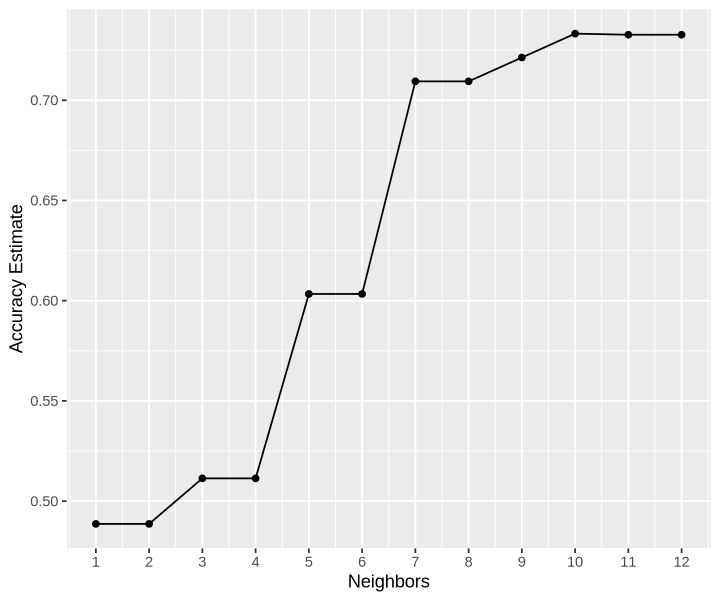

In [562]:
options(repr.plot.height = 5, repr.plot.width = 6)


knn_recipe <- recipe(subscribe ~., data = training_set) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_vfold <- vfold_cv(training_set, v = 3, strata = subscribe)
k_vals = tibble(neighbors = seq(from = 1, to = 12, by = 1))

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = knn_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy") 

cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +  
    scale_x_continuous(breaks = seq(1, 12, by = 1)) 
    theme(text = element_text(size=20))  
cross_val_plot

# error below doesnt impact results



In [565]:
#...

testing_set <- testing_set |>
  mutate(across(where(is.numeric), ~ replace_na(., 0)))

new_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

new_knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(new_knn_spec) |>
    fit(data = training_set)

knn_predictions <- predict(new_knn_fit, testing_set) |>
    bind_cols(testing_set)

knn_predictions

knn_metrics <- knn_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class)


knn_conf_mat <- knn_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class)


knn_precision <- knn_predictions |>
  precision(truth = subscribe, estimate = .pred_class)

knn_recall <- knn_predictions |>
  recall(truth = subscribe, estimate = .pred_class)

knn_metrics

knn_conf_mat

knn_precision

knn_recall

.pred_class,subscribe,age,total_sessions,avg_session_duration,days_active
<fct>,<fct>,<dbl>,<int>,<dbl>,<int>
TRUE,TRUE,9,27,74.77778,18
TRUE,TRUE,21,1,9.00000,1
TRUE,TRUE,19,0,0.00000,0
⋮,⋮,⋮,⋮,⋮,⋮
TRUE,TRUE,17,0,0.00000,0
TRUE,FALSE,17,6,29.83333,3
TRUE,TRUE,0,1,15.00000,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7611940
kap,binary,0.1545741


          Truth
Prediction FALSE TRUE
     FALSE     2    0
     TRUE     16   49

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1111111
